# This notebook is exclusively to create the training data set

In [1]:
# Modues to be used
import pickle
import json
import numpy as np
import pandas as pd

from datetime import datetime

In [2]:
# Load the original data

# -> Player dictionary with the dataFrames
f = open('../data/dict_player.pickle', 'rb')
dict_player = pickle.load(f)

# -> Map dataFrames
f = open('../data/df_map.pickle','rb')
df_map = pickle.load(f)

# -> Map dictionary
f = open('../data/dict_map.pickle','rb')
dict_map = pickle.load(f)

In [165]:

df_map.loc[ df_map['team_rank_1']==0, 'team_rank_1'] = 420

df_map.loc[ df_map['team_rank_2']==0, 'team_rank_2'] = 420

df_map['team_rank_1'].max()

420

In [234]:
df_map.sort_values(['date'],ascending=False).head()

,map_id,map,date,event_id,event_name,team_id_1,team_name_1,team_score_1,team_kills_1,team_deaths_1,team_assists_1,team_rank_1,team_id_2,team_name_2,team_score_2,team_kills_2,team_deaths_2,team_assists_2,team_rank_2,winner
97594,97594,inf,2020-01-10 01:00:00,5164,Aorus League 2019 #4 Northern Cone,10330,Supremacy,16,99.0,93.0,16.0,420,10578,Infamous,12,93.0,100.0,17.0,420,1
97592,97592,nuke,2020-01-10 01:00:00,5164,Aorus League 2019 #4 Northern Cone,10330,Supremacy,16,98.0,69.0,17.0,420,10578,Infamous,8,69.0,98.0,13.0,420,1
97595,97595,inf,2020-01-10 00:35:00,5104,IEM Katowice 2020 North America Closed Qualifier,5752,Cloud9,16,100.0,91.0,14.0,18,9215,MIBR,12,90.0,100.0,16.0,14,1
97593,97593,ovp,2020-01-10 00:35:00,5104,IEM Katowice 2020 North America Closed Qualifier,5752,Cloud9,16,77.0,46.0,11.0,18,9215,MIBR,4,46.0,77.0,10.0,14,1
97591,97591,trn,2020-01-10 00:35:00,5104,IEM Katowice 2020 North America Closed Qualifier,5752,Cloud9,13,90.0,105.0,12.0,18,9215,MIBR,16,105.0,90.0,20.0,14,2


In [729]:
len(( df_map[ (df_map['date']>datetime(2016,6,6)) & (df_map['team_rank_1']<150) &  (df_map['team_rank_2']<150) ] ))

29013

In [730]:
# All unranked teams make them 420
df_map.loc[ df_map['team_rank_1']==0, 'team_rank_1'] = 420
df_map.loc[ df_map['team_rank_2']==0, 'team_rank_2'] = 420

df_map['team_rank_1'].max()

# Loop throughout all of the players and put it in the right map
DAYS_WEIGHT = 90

MAX_RANK = 150
time_1 = datetime.now()


# df_map_ranked = ( df_map[ (df_map['date']>datetime(2016,6,6)) & (df_map['team_rank_1']>0) &  (df_map['team_rank_2']>0) ] )
df_map_ranked = ( df_map[ (df_map['date']>datetime(2016,6,6)) & (df_map['team_rank_1']<MAX_RANK) &  (df_map['team_rank_2']<MAX_RANK) ] )

df_map_ranked = df_map_ranked.sort_values(['date'],ascending=False)

metric_vec = ['KAST', 'ADR', 'first_kills_diff', 'rating',
       'kills_per_round', 'deaths_per_round', 'impact', 
       'team_score',
       'op_score', 'win', 'team_rank', 'prize']

map_training_dict = {}


# Function to append values of all the players
def append_val(team_01,stat_vec,stat_name,dict_inout):

    n = len(stat_vec)
    order = np.argsort( stat_vec )[::-1][:n]

    count_p = -1
    for ind in order:
        count_p = count_p + 1
        dict_inout['t_'+team_01+'_p_'+str(count_p)+'_'+stat_name] = stat_vec[ind]
    
    return dict_inout

for map_id in df_map_ranked['map_id'][:]:
    
    map_training_dict[map_id] = {}

    # Keys for the dictionary
    map_training_dict[map_id]['t1_win']    = 0
    map_training_dict[map_id]['fav_win']   = 0
    map_training_dict[map_id]['fav_ind']   = 0
    map_training_dict[map_id]['map']       = df_map_ranked.at[map_id,'map']
    map_training_dict[map_id]['score_dif'] = 0
    map_training_dict[map_id]['t1_rank']   = 0
    map_training_dict[map_id]['t2_rank']   = 0

    # Get who started CT
    # for t in range(0,2):
    #     for p in range(0,5):
    #         for metric in metric_vec:
    #             map_training_dict[map_id][
    #                 't_'+str(t)+'_p_'+str(p)+'_'+metric] = {}

    with open('/home/emmanuel/Desktop/csgo-csv/json_maps/hltv_map_'+str(map_id)+'.json') as f:

        data = json.load(f)
        id_ct_start = data['roundHistory'][0]['ctTeam']

    team_1  = df_map.at[map_id,'team_id_1']
    rank_1  = df_map.at[map_id,'team_rank_1']
    score_1 = df_map.at[map_id,'team_score_1']

    team_2  = df_map.at[map_id,'team_id_2']
    rank_2  = df_map.at[map_id,'team_rank_2']
    score_2 = df_map.at[map_id,'team_score_2']

    if team_1 != id_ct_start:
        # We swap them
        team_aux  = team_1
        rank_aux  = rank_1
        score_aux = score_1

        team_1  = team_2
        rank_1  = rank_2
        score_1 = score_2

        team_2  = team_aux
        rank_2  = rank_aux
        score_2 = score_aux

    map_training_dict[map_id]['score_dif'] = score_1-score_2
    map_training_dict[map_id]['t1_rank']   = rank_1
    map_training_dict[map_id]['t2_rank']   = rank_2
    

    if score_1 > score_2:
        map_training_dict[map_id]['t1_win'] = 1
    else:
        map_training_dict[map_id]['t1_win'] = 0


    if map_training_dict[map_id]['t1_rank'] < map_training_dict[map_id]['t2_rank']:
        map_training_dict[map_id]['fav_ind'] = 1
    else:
        map_training_dict[map_id]['fav_ind'] = 2


    if ( (map_training_dict[map_id]['score_dif'] > 0) & (map_training_dict[map_id]['t1_rank']<map_training_dict[map_id]['t2_rank']) )|( (map_training_dict[map_id]['score_dif'] < 0) & (map_training_dict[map_id]['t2_rank']<map_training_dict[map_id]['t1_rank']) ):
        map_training_dict[map_id]['fav_win'] = 1


    # Now we fill the player statistics -----------------------------------------#
    map_date = df_map_ranked.loc[map_id]['date']

    # Here we are taking the rankings to be non-zero
    team_vec = [team_1, team_2]
    
    for ind in range(0,2):

        team_id = team_vec[ind]

        rating_vec    = []
        prize_rtg_vec = []
        hs_vec        = []
        kills_per_rd_vec  = []
        deaths_per_rd_vec = []
        adr_vec = []
        kast_vec = []
        assists_per_rd_vec = []
        flash_per_rd_vec   = []
        first_kills_dif_vec = []
        team_rank_vec = []
        score_dif_vec = []
        win_rate_vec = []
        win_rate_map_vec = []

        kd_per_round_vec  = []

        scaled_win_vec = []
        scaled_rating_vec = [] 
        scaled_score_dif_vec = []
        scaled_kd_vec = []

        momentum_vec = []
        map_rating_vec = []

        for player_id in dict_map[map_id][team_id]['players_id']:            
            
            # Get the data for this player
            df_aux   = dict_player[player_id]
            date_vec = (map_date-df_aux['date']).astype('timedelta64[D]')

            # Note the prize rating we take a whole year back
            prize = df_aux[ (date_vec>1) & (date_vec<365) ]['prize'].sum()
            if prize > 0.0:
                prize_rtg_vec.append( np.log( prize )/12.0 )
            else:
                prize_rtg_vec.append( 0.0 )


            df_aux   = df_aux[ (date_vec>1) & (date_vec<DAYS_WEIGHT) ]

            # What if we use only the historical data for this map in particular
            # df_aux = df_aux[ (date_vec>1) & (date_vec<DAYS_WEIGHT) & (df_aux['map']==df_map_ranked.at[map_id,'map']) ]

            # Append the average values of this player 
            rating_vec.append         ( df_aux['rating'].mean() )
            hs_vec.append             ( (df_aux['hs_kills']/(df_aux['team_score']+df_aux['op_score'])).mean() )        
            kills_per_rd_vec.append   ( df_aux['kills_per_round'].mean() )
            deaths_per_rd_vec.append  ( df_aux['deaths_per_round'].mean() )
            adr_vec.append            ( df_aux['ADR'].mean() )
            kast_vec.append           ( df_aux['KAST'].mean() )
            assists_per_rd_vec.append ( (df_aux['assists']/(df_aux['team_score']+df_aux['op_score'])).mean() )
            flash_per_rd_vec.append   ( (df_aux['flash_assists']/(df_aux['team_score']+df_aux['op_score'])).mean() )
            first_kills_dif_vec.append( (df_aux['first_kills_diff']/(df_aux['team_score']+df_aux['op_score'])).mean() )
            team_rank_vec.append      ( df_aux['team_rank'].mean() )
            score_dif_vec.append      ( (df_aux['team_score']-df_aux['op_score']).mean() )
            win_rate_vec.append       ( df_aux['win'].mean() )

            

            kd_per_round_vec.append  ( (df_aux['kills_per_round']-df_aux['deaths_per_round']).mean() )

            # Get the opponent rank
            df_player_maps = df_map.loc[df_aux.index.values]
            op_rank_vec    = (df_aux['team_id']!=df_player_maps['team_id_1'])*df_player_maps['team_rank_1'] + (df_aux['team_id']!=df_player_maps['team_id_2'])*df_player_maps['team_rank_2']

            # Scaled Variables
            
            # Linear scaling
            # alpha = 0.1
            # op_rank_vec = alpha + (1.0-alpha)*(420.0-op_rank_vec)/420.0
            
            # scaled_win_vec.append       ( (df_aux['win']*op_rank_vec).mean() )
            # scaled_rating_vec.append    ( (df_aux['rating']*op_rank_vec).mean() )
            # scaled_score_dif_vec.append ( ((df_aux['team_score']-df_aux['op_score'])*op_rank_vec).mean() )

            scaled_win_vec.append       ( (df_aux['win']/op_rank_vec).mean() )
            scaled_rating_vec.append    ( (df_aux['rating']/op_rank_vec).mean() )
            scaled_score_dif_vec.append ( ((df_aux['team_score']-df_aux['op_score'])/op_rank_vec).mean() )

            scaled_kd_vec.append ( ((df_aux['kills_per_round']-df_aux['deaths_per_round'])/op_rank_vec).mean() )

            momentum_vec.append ( df_aux['win'].head(n=15).mean() )

            df_aux_map = df_aux[ df_aux['map']==df_map_ranked.at[map_id,'map'] ]
            map_rating_vec.append( (df_aux_map['team_score']-df_aux_map['op_score']).mean() )
            win_rate_map_vec.append ( (df_aux_map['win']/op_rank_vec).mean() )


        t = str(ind)

        map_training_dict[map_id] = append_val(t,prize_rtg_vec,'prize_rating',map_training_dict[map_id])

        map_training_dict[map_id] = append_val(t,rating_vec,'rating',map_training_dict[map_id])
        map_training_dict[map_id] = append_val(t,hs_vec,'hs_perc',map_training_dict[map_id])
        map_training_dict[map_id] = append_val(t,kills_per_rd_vec,'kills_per_rd',map_training_dict[map_id])
        map_training_dict[map_id] = append_val(t,deaths_per_rd_vec,'deaths_per_rd',map_training_dict[map_id])
        map_training_dict[map_id] = append_val(t,adr_vec,'adr',map_training_dict[map_id])
        map_training_dict[map_id] = append_val(t,kast_vec,'kast',map_training_dict[map_id])
        map_training_dict[map_id] = append_val(t,assists_per_rd_vec,'assists_per_rd',map_training_dict[map_id])
        map_training_dict[map_id] = append_val(t,flash_per_rd_vec,'flash_per_rd',map_training_dict[map_id])
        map_training_dict[map_id] = append_val(t,first_kills_dif_vec,'first_kills_dif',map_training_dict[map_id])
        map_training_dict[map_id] = append_val(t,team_rank_vec,'team_rank',map_training_dict[map_id])
        map_training_dict[map_id] = append_val(t,score_dif_vec,'score_dif',map_training_dict[map_id])
        map_training_dict[map_id] = append_val(t,win_rate_vec,'win_rate',map_training_dict[map_id])

        map_training_dict[map_id] = append_val(t,win_rate_map_vec,'win_rate_map',map_training_dict[map_id])

        map_training_dict[map_id] = append_val(t,kd_per_round_vec,'kd_per_round',map_training_dict[map_id])

        map_training_dict[map_id] = append_val(t,scaled_win_vec,'scaled_win',map_training_dict[map_id])
        map_training_dict[map_id] = append_val(t,scaled_rating_vec,'scaled_rating',map_training_dict[map_id])
        map_training_dict[map_id] = append_val(t,scaled_score_dif_vec,'scaled_score_dif',map_training_dict[map_id])

        map_training_dict[map_id] = append_val(t,scaled_kd_vec,'scaled_kd',map_training_dict[map_id])

        map_training_dict[map_id] = append_val(t,momentum_vec,'momentum',map_training_dict[map_id])
        map_training_dict[map_id] = append_val(t,map_rating_vec,'map_rating',map_training_dict[map_id])
    
print('Converting data to DataFrame')
df_ct_start = pd.DataFrame.from_dict( map_training_dict,orient='index')
time_2 = datetime.now()

print( time_2-time_1 )

Converting data to DataFrame
0:58:55.156098


In [764]:
filename = 'final_train_df.sav'
pickle.dump( df_ct_start, open(filename,'wb') )

In [385]:
df_all_feat = pd.DataFrame.from_dict(map_training_dict,orient='index')

df_all_feat = df_all_feat.fillna(0)

# filename = 'df_all_feat_40000.sav'
# pickle.dump( df_all_feat, open(filename,'wb') )

df_all_feat.head(n=20)

,t1_win,fav_win,fav_ind,map,score_dif,t1_rank,t2_rank,t_0_p_0_prize_rating,t_0_p_1_prize_rating,t_0_p_2_prize_rating,...,t_1_p_0_scaled_score_dif,t_1_p_1_scaled_score_dif,t_1_p_2_scaled_score_dif,t_1_p_3_scaled_score_dif,t_1_p_4_scaled_score_dif,t_1_p_0_scaled_kd,t_1_p_1_scaled_kd,t_1_p_2_scaled_kd,t_1_p_3_scaled_kd,t_1_p_4_scaled_kd
92838,0,1,2,mrg,-6,19,8,0.854439,0.852957,0.834175,...,-0.104174,-0.104174,-0.104174,-0.104174,-0.104174,0.004472,0.001304,-0.002880,-0.007629,-0.010502
92845,0,0,1,nuke,-6,1,28,1.032929,1.032929,1.032929,...,0.026481,-0.162239,-0.162239,-0.162239,-0.162239,0.005567,0.001263,-0.005819,-0.005870,-0.016589
92846,1,1,1,nuke,3,8,19,0.930477,0.898823,0.898823,...,-0.573629,-0.586402,-0.608132,-0.608132,-0.608132,0.001080,-0.022336,-0.027359,-0.028091,-0.028422
92855,1,1,1,d2,10,25,35,0.810288,0.810288,0.810288,...,0.009982,0.009182,0.008159,0.008159,0.008159,0.002185,0.000116,-0.000172,-0.000673,-0.001232
92856,0,1,2,vertigo,-11,5,2,0.962391,0.960731,0.960731,...,0.236011,0.236011,0.236011,0.236011,0.236011,0.024258,0.014221,0.004867,-0.001036,-0.017150
92860,1,0,2,ovp,2,23,13,0.910906,0.910906,0.910906,...,0.226649,0.226649,0.226649,0.226649,-0.174910,0.017286,0.015257,0.001157,0.000660,-0.003709
92868,1,1,1,d2,2,2,5,1.063768,1.063768,1.063768,...,-0.160592,-0.747932,-0.747932,-0.747932,-0.747932,0.017874,0.011226,-0.021122,-0.045754,-0.049187
92873,0,0,1,trn,-2,30,49,0.894170,0.813129,0.774684,...,0.027949,0.027949,0.026007,0.026007,-0.040171,0.002331,0.000786,0.000098,-0.002182,-0.003897
92875,0,0,1,inf,-11,13,23,0.925763,0.924979,0.924979,...,0.062518,0.062518,0.062518,-0.057540,-0.287111,0.009369,0.007487,-0.002798,-0.003668,-0.021964
92878,0,1,2,ovp,-8,17,10,0.921959,0.921959,0.921959,...,-0.376298,-0.376298,-0.376298,-0.376298,-1.467185,0.015798,0.013924,0.002607,-0.004257,-0.041581


In [731]:
# Here we do some feature engineering
df_all_feat = pd.DataFrame.from_dict(map_training_dict,orient='index')

df_all_feat = df_all_feat.fillna(0)

#df_train = pd.DataFrame()

df_train = df_all_feat[['fav_win','t1_win','fav_ind']].copy()

feat_names = ['prize_rating','rating','hs_perc','kills_per_rd','deaths_per_rd','adr',
                'kast','assists_per_rd','flash_per_rd','first_kills_dif','team_rank','score_dif','win_rate',
                'scaled_win','scaled_rating','scaled_score_dif','win_rate_map','kd_per_round','scaled_kd','momentum','map_rating']

for feat in feat_names:

    avg_0 = 0.0*df_all_feat['t_1_p_0_rating']
    avg_1 = 0.0*df_all_feat['t_1_p_1_rating']

    vec_both = []

    for ind in range(0,5):
        # df_train[feat+'_p_'+str(ind)+'_dif'] = df_all_feat['t_0_p_'+str(ind)+'_'+feat] - df_all_feat['t_1_p_'+str(ind)+'_'+feat]

        avg_0 = avg_0 + df_all_feat['t_0_p_'+str(ind)+'_'+feat]
        avg_1 = avg_1 + df_all_feat['t_1_p_'+str(ind)+'_'+feat]

        # Normalized
        # avg_0 = avg_0 + (df_all_feat['t_0_p_'+str(ind)+'_'+feat]-df_all_feat['t_0_p_'+str(ind)+'_'+feat].mean())/df_all_feat['t_0_p_'+str(ind)+'_'+feat].std()
        # avg_1 = avg_1 + (df_all_feat['t_1_p_'+str(ind)+'_'+feat]-df_all_feat['t_1_p_'+str(ind)+'_'+feat].mean())/df_all_feat['t_1_p_'+str(ind)+'_'+feat].std()

        vec_both.append( df_all_feat['t_0_p_'+str(ind)+'_'+feat].values ) 
        vec_both.append( df_all_feat['t_1_p_'+str(ind)+'_'+feat].values ) 
   
    # Normalize
    avg_0 = (avg_0 - np.mean(vec_both)) / np.std(vec_both)
    avg_1 = (avg_1 - np.mean(vec_both)) / np.std(vec_both)

    df_train[feat+'_dif'] = ( avg_0 - avg_1 ) / 5.0

    # Take the first and last
    # ind = 0
    # df_train[feat+'_p_'+str(ind)+'_dif'] = df_all_feat['t_0_p_'+str(ind)+'_'+feat] - df_all_feat['t_1_p_'+str(ind)+'_'+feat]

    # ind = 4
    # df_train[feat+'_p_'+str(ind)+'_dif'] = df_all_feat['t_0_p_'+str(ind)+'_'+feat] - df_all_feat['t_1_p_'+str(ind)+'_'+feat]
    
# df_train['prize_rating_dif'] = np.sqrt( abs( df_train['prize_rating_dif'] )) *np.sign(df_train['prize_rating_dif']) 

# Does it help if we normalize everything?
# df_train['norm_dif'] = 0.0


# for column in df_train:
#     if (column != 'fav_win') & (column !='t1_win') & (column !='fav_ind') & (column != 'norm_dif'):
        
#         df_train[column] = (df_train[column]-df_train[column].mean())/df_train[column].std()

        # Try using the norm of the difference
        # df_train['norm_dif'] = df_train['norm_dif'] + df_train[column]

        # Try using a sigmoid function to exagerate the feature difference for small changes
        # df_train[column] = np.arctan( 0.50*df_train[column] )

# df_train['norm_dif'] = df_train['norm_dif'] * np.sign( df_train['rating_dif'] ) / df_train['norm_dif'].max()
# df_train['norm_dif'] = np.sign( df_train['rating_dif'] )* (df_train['rating_dif']**2 + df_train['prize_rating_dif']**2 )

df_train['tier_1'] = np.ceil( df_all_feat['t1_rank'] / 20.0 )
df_train['tier_2'] = np.ceil( df_all_feat['t2_rank'] / 20.0 )

df_train = df_train.fillna(0)


df_train['fav_ind'] = -1.0*(df_train['prize_rating_dif']>=0.0) + 1.0*(df_train['prize_rating_dif']<0.0)

df_train['fav_ind_2'] = -1.0*(df_train['rating_dif']>=0.0) + 1.0*(df_train['rating_dif']<0.0)

df_train['fav_ind_3'] = -1.0*(df_train['kills_per_rd_dif']>=0.0) + 1.0*(df_train['kills_per_rd_dif']<0.0)

# df_train['prize_rating_dif'] = np.sign(df_train['prize_rating_dif'])*(np.abs(df_train['prize_rating_dif'])**0.1)

# df_train['scaled_win_dif'] = np.sign(df_train['scaled_win_dif'])*(np.abs(df_train['scaled_win_dif'])**2)

#print(df_train.keys())

print(df_train['t1_win'].mean())

df_train.tail(n=80)

0.5008789163478441


,fav_win,t1_win,fav_ind,prize_rating_dif,rating_dif,hs_perc_dif,kills_per_rd_dif,deaths_per_rd_dif,adr_dif,kast_dif,...,scaled_score_dif_dif,win_rate_map_dif,kd_per_round_dif,scaled_kd_dif,momentum_dif,map_rating_dif,tier_1,tier_2,fav_ind_2,fav_ind_3
97490,0,0,-1.0,0.703403,-0.348008,-0.425264,-0.416823,0.214299,-0.376182,-0.254745,...,-1.124069,-0.126876,-0.541530,-0.874358,-1.353951,-1.084605,2.0,4.0,1.0,1.0
97491,1,0,-1.0,1.343076,2.005799,0.646436,1.535165,1.321096,1.654750,2.972975,...,0.053010,-0.002953,0.504626,0.025537,2.080160,-0.470765,6.0,5.0,-1.0,-1.0
97492,0,0,1.0,-0.255373,0.010410,-0.169967,0.017783,-0.082043,-0.083886,0.005859,...,-0.770420,0.006047,0.074568,-0.689170,-1.846296,-0.973705,2.0,2.0,-1.0,-1.0
97493,1,0,1.0,-0.703403,0.348008,0.425264,0.416823,-0.214299,0.376182,0.254745,...,1.124069,-0.379142,0.541530,0.874358,1.353951,-1.892290,4.0,2.0,-1.0,-1.0
97494,0,1,-1.0,0.255373,-0.010410,0.169967,-0.017783,0.082043,0.083886,-0.005859,...,0.770420,0.101901,-0.074568,0.689170,1.846296,0.354458,2.0,2.0,1.0,1.0
97495,1,0,1.0,-0.970588,0.168361,-0.103084,0.014974,-0.523512,0.006196,0.153213,...,0.527784,-0.224120,0.383600,0.272026,-1.200093,-1.079990,4.0,2.0,-1.0,-1.0
97496,0,0,-1.0,0.970588,-0.168361,0.103084,-0.014974,0.523512,-0.006196,-0.153213,...,-0.527784,0.283226,-0.383600,-0.272026,1.200093,1.199989,2.0,4.0,1.0,1.0
97497,1,0,1.0,-0.693781,0.018406,-0.026862,0.029209,0.035314,-0.036594,0.041797,...,0.531486,-0.272841,0.002416,0.576347,-1.144704,0.663215,3.0,2.0,-1.0,-1.0
97498,1,1,-1.0,0.771150,-0.803193,-0.494025,-0.387243,0.735595,-0.533368,-0.543970,...,-0.461861,0.172086,-0.881853,-0.300319,-0.640049,-1.964203,1.0,2.0,1.0,1.0
97501,1,1,-1.0,0.264992,-0.410980,0.347706,-0.215865,0.624402,-0.281998,-0.114748,...,-1.710859,1.203514,-0.642904,-1.274541,-1.200093,-3.026346,1.0,2.0,1.0,1.0


In [483]:
df_train[['fav_win', 't1_win', 'fav_ind', 'map_rating_dif']].head(n=100)

,fav_win,t1_win,fav_ind,map_rating_dif
92838,1,0,1.0,-0.810772
92845,0,0,-1.0,1.340639
92846,1,1,-1.0,-0.055113
92855,1,1,-1.0,0.047574
92856,1,0,1.0,0.462612
92860,0,1,1.0,-0.712879
92868,1,1,-1.0,0.634560
92873,0,0,1.0,-2.254641
92875,0,0,-1.0,2.075389
92878,1,0,1.0,0.613673


In [173]:
#pd.DataFrame.describe()
df_train.describe()

# %matplotlib qt

# sns.set_style("whitegrid")
# sns.set(font_scale=3)

# plt.figure(figsize=(30,20));
# ax = plt.axes()

# df_train.hist(ax=ax)

,fav_win,t1_win,fav_ind,prize_rating_dif,rating_dif,hs_perc_dif,kills_per_rd_dif,deaths_per_rd_dif,adr_dif,kast_dif,assists_per_rd_dif,flash_per_rd_dif,first_kills_dif_dif,team_rank_dif,score_dif_dif,win_rate_dif,scaled_win_dif,scaled_rating_dif,scaled_score_dif_dif
count,1000.000000,1000.000000,1000.000000,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03
mean,0.605000,0.495000,1.506000,-5.329071e-18,3.552714e-18,1.776357e-18,1.065814e-17,3.552714e-18,7.105427e-18,-1.065814e-17,-4.440892e-18,1.332268e-17,1.065814e-17,-7.105427e-18,3.552714e-17,-3.197442e-17,3.552714e-18,-3.552714e-18,-2.309264e-17
std,0.489095,0.500225,0.500214,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,0.000000,0.000000,1.000000,-4.294535e+00,-7.087553e+00,-6.435974e+00,-7.735193e+00,-7.817805e+00,-8.118688e+00,-8.099462e+00,-5.048495e+00,-6.284287e+00,-4.760382e+00,-3.583056e+00,-4.217007e+00,-3.724805e+00,-1.128112e+01,-5.958851e+00,-7.928005e+00
25%,0.000000,0.000000,1.000000,-4.468085e-01,-3.924654e-01,-4.381664e-01,-3.243540e-01,-3.263356e-01,-2.815156e-01,-2.678898e-01,-5.383833e-01,-5.687058e-01,-5.859129e-01,-4.851744e-01,-5.956345e-01,-6.036420e-01,-1.568888e-01,-2.703883e-01,-1.762917e-01
50%,1.000000,0.000000,2.000000,1.314647e-03,3.299395e-02,2.559003e-02,4.188134e-02,4.807448e-02,3.512834e-02,6.239436e-02,1.682523e-02,1.543661e-02,-2.020498e-02,1.221722e-02,2.430884e-02,3.373862e-03,7.291137e-02,-1.931123e-03,1.044269e-01
75%,1.000000,1.000000,2.000000,4.447292e-01,4.738720e-01,5.452574e-01,4.213216e-01,4.289761e-01,3.676461e-01,3.678864e-01,5.776503e-01,5.976279e-01,6.196910e-01,4.602681e-01,5.966732e-01,6.204561e-01,2.741010e-01,2.377506e-01,3.057342e-01
max,1.000000,1.000000,2.000000,4.291147e+00,6.331305e+00,6.316330e+00,7.090528e+00,7.788433e+00,7.684703e+00,7.808019e+00,5.311427e+00,6.438761e+00,4.460250e+00,4.320149e+00,3.464001e+00,4.228936e+00,4.603757e+00,5.245539e+00,8.470654e+00


In [174]:
df_train[df_train['t1_win']==1][['prize_rating_dif','scaled_win_dif']].describe()

,prize_rating_dif,scaled_win_dif
count,495.000000,495.000000
mean,0.227814,0.156660
std,0.972410,0.921393
min,-4.294535,-6.860687
25%,-0.252996,-0.037509
50%,0.177084,0.134580
75%,0.584404,0.352129
max,4.114808,4.603757


In [175]:
df_train[df_train['t1_win']==0][['prize_rating_dif','scaled_win_dif']].describe()

,prize_rating_dif,scaled_win_dif
count,505.000000,505.000000
mean,-0.223303,-0.153558
std,0.976928,1.049901
min,-4.294535,-11.281118
25%,-0.638892,-0.259403
50%,-0.178711,0.002556
75%,0.245448,0.183122
max,4.291147,3.242652


In [47]:
correlations = df_train.drop(['fav_win'],axis=1).corr()

%matplotlib qt

sns.set_style("whitegrid")
sns.set(font_scale=1)
plt.figure(figsize=(20,16));
ax = plt.axes()

sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70}, ax=ax)

In [337]:
df_ct_start = pd.DataFrame.from_dict( map_training_dict,orient='index')
len( df_ct_start )

# type(data['roundHistory'][0]['ctTeam'])
df_ct_start.tail()

,t1_win,fav_win,fav_ind,map,score_dif,t1_rank,t2_rank,t_0_p_0_prize_rating,t_0_p_1_prize_rating,t_0_p_2_prize_rating,...,t_1_p_0_scaled_rating,t_1_p_1_scaled_rating,t_1_p_2_scaled_rating,t_1_p_3_scaled_rating,t_1_p_4_scaled_rating,t_1_p_0_scaled_score_dif,t_1_p_1_scaled_score_dif,t_1_p_2_scaled_score_dif,t_1_p_3_scaled_score_dif,t_1_p_4_scaled_score_dif
96641,0,1,2,trn,-10,97,41,0.663651,0.629862,0.569225,...,0.043875,0.039537,0.034187,0.032402,0.029116,-0.098653,-0.102610,-0.102610,-0.102906,-0.102906
96639,1,1,1,inf,8,41,97,0.721413,0.709766,0.709069,...,0.097023,0.008072,0.007778,0.007525,0.006096,-0.016848,-0.021450,-0.021450,-0.022641,-0.820086
96638,1,1,1,mrg,8,35,48,0.818040,0.799803,0.799803,...,0.026508,0.022743,0.022248,0.021855,0.019667,-0.024231,-0.024263,-0.024263,-0.025765,-0.033227
96634,0,1,2,trn,-2,48,35,0.726537,0.726537,0.720326,...,0.063923,0.055480,0.054788,0.052385,0.028128,-0.077340,-0.136681,-0.136681,-0.136681,-0.139161
96624,0,1,2,nuke,-3,84,35,0.699892,0.697520,0.697520,...,0.063923,0.055480,0.054788,0.052385,0.028128,-0.077340,-0.136681,-0.136681,-0.136681,-0.139161


In [349]:
df_ct_start.tail(n=20)
print(df_ct_start[df_ct_start['map']=='inf']['t1_win'].mean())
#df_ct_start['t1_rank'].max()
print(df_ct_start['fav_win'].mean())

0.49171270718232046
0.574


In [242]:
df_train[['fav_win','tier_1','tier_2','team_rank_dif']].head(n=30)
# X = df_train.iloc[:, 2:15]
# np.shape(X)

,fav_win,tier_1,tier_2,team_rank_dif
95444,1,6.0,7.0,-0.444945
95448,0,5.0,3.0,0.582442
95451,0,3.0,5.0,-0.336810
95454,1,9.0,12.0,0.041625
95455,1,12.0,9.0,0.209711
95457,0,6.0,3.0,0.158154
95458,0,10.0,9.0,0.949587
95463,0,6.0,3.0,-0.318071
95466,0,9.0,10.0,-0.996637
95488,0,6.0,8.0,-1.530299


In [549]:
df_train.keys().values

array(['fav_win', 't1_win', 'fav_ind', 'prize_rating_dif', 'rating_dif',
       'hs_perc_dif', 'kills_per_rd_dif', 'deaths_per_rd_dif', 'adr_dif',
       'kast_dif', 'assists_per_rd_dif', 'flash_per_rd_dif',
       'first_kills_dif_dif', 'team_rank_dif', 'score_dif_dif',
       'win_rate_dif', 'scaled_win_dif', 'scaled_rating_dif',
       'scaled_score_dif_dif', 'win_rate_map_dif', 'kd_per_round_dif',
       'scaled_kd_dif', 'momentum_dif', 'map_rating_dif', 'tier_1',
       'tier_2', 'fav_ind_2', 'fav_ind_3'], dtype=object)

In [811]:
# Quick XGBoost
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
#from sklearn.metrics import cross_validation   #Additional scklearn functions
#from sklearn.model_selection import GridSearchCV   #Perforing grid search

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import plot_roc_curve
from sklearn import metrics

# model = XGBClassifier(
#     learning_rate =0.1,
#     n_estimators=600,
#     max_depth=5,
#     min_child_weight=5,
#     gamma=1,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     objective= 'binary:logistic',
#     nthread=4,
#     scale_pos_weight=1,
#     seed=0)



all_keys = ['fav_ind','prize_rating_dif', 'rating_dif', 'hs_perc_dif',
       'kills_per_rd_dif', 'deaths_per_rd_dif', 'adr_dif', 'kast_dif',
       'assists_per_rd_dif', 'flash_per_rd_dif', 'first_kills_dif_dif',
       'team_rank_dif', 'score_dif_dif', 'win_rate_dif',
       'scaled_win_dif','scaled_rating_dif','scaled_score_dif']

features = ['t1_win','tier_1','tier_2','fav_ind','fav_ind_2','fav_ind_3','prize_rating_dif', 'rating_dif', 'deaths_per_rd_dif', 
       'assists_per_rd_dif', 'flash_per_rd_dif', 'first_kills_dif_dif',
       'score_dif_dif', 'win_rate_dif','scaled_win_dif',
       'scaled_rating_dif','scaled_score_dif_dif','win_rate_map_dif']


features = ['t1_win', 'fav_ind', 'prize_rating_dif', 'rating_dif',
       'hs_perc_dif', 'kills_per_rd_dif', 'deaths_per_rd_dif', 'adr_dif',
       'kast_dif', 'assists_per_rd_dif', 'flash_per_rd_dif',
       'first_kills_dif_dif', 'team_rank_dif', 'score_dif_dif',
       'win_rate_dif', 'scaled_win_dif', 'scaled_rating_dif',
       'scaled_score_dif_dif', 'win_rate_map_dif', 'kd_per_round_dif',
       'scaled_kd_dif', 'tier_1', 'tier_2', 'fav_ind_2', 'fav_ind_3','momentum_dif','map_rating_dif']

# These features are giving 63%
features = ['t1_win', 'prize_rating_dif',  'score_dif_dif', 
        'win_rate_dif', 'scaled_win_dif', 'scaled_rating_dif','win_rate_map_dif', 'kd_per_round_dif',
        'map_rating_dif', 'momentum_dif']



# features = ['t1_win', 'fav_ind', 'prize_rating_dif', 'rating_dif',
#        'hs_perc_dif', 'kills_per_rd_dif', 'deaths_per_rd_dif', 'adr_dif',
#        'kast_dif', 'assists_per_rd_dif', 'flash_per_rd_dif',
#        'first_kills_dif_dif', 'team_rank_dif', 'score_dif_dif',
#        'win_rate_dif', 'scaled_win_dif', 'scaled_rating_dif',
#        'scaled_score_dif_dif', 'win_rate_map_dif', 'kd_per_round_dif',
#        'scaled_kd_dif', 'momentum_dif', 'map_rating_dif', 'tier_1',
#        'tier_2', 'fav_ind_2', 'fav_ind_3']


# features = ['t1_win','fav_ind','fav_ind_2']

# features = ['t1_win','win_rate_dif','team_rank_dif']

# df_tmp = df_train[ features ].head(n=10000).copy()

df_tmp = df_train[ features ].copy()

# Get rid of outliers
df_tmp = df_tmp[ np.abs(df_tmp['win_rate_map_dif'])<3.0  ]
# df_tmp = df_tmp[ np.abs(df_tmp['adr_dif'])<3.0  ]
# df_tmp = df_tmp[ np.abs(df_tmp['assists_per_rd_dif'])<3.0  ]
# df_tmp = df_tmp[ np.abs(df_tmp['deaths_per_rd_dif'])<3.0  ]
df_tmp = df_tmp[ np.abs(df_tmp['kd_per_round_dif'])<3.0  ]
# df_tmp = df_tmp[ np.abs(df_tmp['map_rating_dif'])<3.0  ]
# df_tmp = df_tmp[ np.abs(df_tmp['scaled_win_dif'])<3.0  ]
# df_tmp = df_tmp[ np.abs(df_tmp['scaled_score_dif_dif'])<3.0  ]


# df_tmp = df_tmp[ np.abs(df_tmp['team_rank_dif'])<1.5]

n = len(df_tmp.keys())
X = df_tmp.iloc[:, 1:n].values
y = df_tmp.iloc[:, 0].values

# Scale all variables to [0,1]
# scaler = MinMaxScaler(feature_range=(0, 1))
# X = scaler.fit_transform(X)


cv = KFold(n_splits=10, random_state=None, shuffle=True)


model = XGBClassifier(
        learning_rate=0.01,
        n_estimators=500,
        max_depth=3,
        min_child_weight=1,
        gamma=10,
        subsample=0.8,
        colsample_bytree=0.6,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1 )

clf = RandomForestClassifier(n_estimators=200,max_depth=8, random_state=1, bootstrap=False,n_jobs=6)


accuracy_vec = []

for train_index, test_index in cv.split(X):
#for test_index, train_index in cv.split(X):
    # print("Train Index: ", train_index, "\n")
    # print("Test Index: ", test_index)

    X_train, X_test, y_train, y_test = X[train_index,:], X[test_index,:], y[train_index], y[test_index]
    # best_svr.fit(X_train, y_train)
    # scores.append(best_svr.score(X_test, y_test))
    
#     model.fit(X_train,y_train) 
#     y_pred = model.predict(X_test)
#     y_train_pred = model.predict(X_train)
#     y_train_proba = model.predict_proba(X_train)[:,1]

    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_train_pred = clf.predict(X_train)
    y_train_proba = clf.predict_proba(X_train)[:,1]

    predictions = [round(value) for value in y_pred]
    

    print('--------------------------------------------------------------')
    print('XGBoost')
    print('')
    print('Accuracy (Train): %.4g' % accuracy_score(y_train, y_train_pred) )
    print('AUC Score (Train): %f' % roc_auc_score(y_train, y_train_proba) )
    print('')
    print('>'+classification_report(y_test,predictions,target_names=['T Start','CT Start']))

    print('Accuracy (Test): %.4g' % accuracy_score(y_test, y_pred) )
    print('AUC Score (Test): %f' % roc_auc_score(y_test, y_pred) )

    accuracy_vec.append( accuracy_score(y_test, y_pred) )


print('--------------------------------------------------------------')
print('Avg accuracy (Test) = %f' % np.mean(accuracy_vec) )
print('--------------------------------------------------------------')

#     sns.set_style("whitegrid")
#     sns.set(font_scale=3)

#     plt.figure(figsize=(10,8));
#     ax = plt.axes()

#     metrics.plot_roc_curve(model, X_test, y_test, ax=ax, lw=6)  # doctest: +SKIP

#     ax.plot([0, 1], [0, 1], linestyle='--', lw=6, color='r',
#             label='Chance', alpha=.8 )

#     plt.show()


--------------------------------------------------------------
XGBoost

Accuracy (Train): 0.6846
AUC Score (Train): 0.756250

>              precision    recall  f1-score   support

     T Start       0.62      0.63      0.62      1404
    CT Start       0.62      0.62      0.62      1403

   micro avg       0.62      0.62      0.62      2807
   macro avg       0.62      0.62      0.62      2807
weighted avg       0.62      0.62      0.62      2807

Accuracy (Test): 0.622
AUC Score (Test): 0.622014
--------------------------------------------------------------
XGBoost

Accuracy (Train): 0.6827
AUC Score (Train): 0.754151

>              precision    recall  f1-score   support

     T Start       0.61      0.63      0.62      1346
    CT Start       0.65      0.63      0.64      1461

   micro avg       0.63      0.63      0.63      2807
   macro avg       0.63      0.63      0.63      2807
weighted avg       0.63      0.63      0.63      2807

Accuracy (Test): 0.6323
AUC Score (Test): 

In [812]:
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)

order = np.argsort( clf.feature_importances_ )[::-1][:n]
feat_new = [features[order[ind]+1] for ind in range(0,n-1)]

df = pd.DataFrame( {'importance':np.array(clf.feature_importances_[order]), 
    'features':feat_new, 'std':std[order]} )


dic_aux = {}
dic_aux['feature'] = []
dic_aux['importance'] = []
count = -1
for tree in clf.estimators_:
    count = count+1
    
    for ind in range(0,n-1):
        dic_aux['feature'].append( features[ind+1] )
        dic_aux['importance'].append( tree.feature_importances_[ind] )

df = pd.DataFrame.from_dict(dic_aux,orient="columns")

sns.set_style("whitegrid")
sns.set(font_scale=3)

plt.figure(figsize=(15,20));
ax = plt.axes()
ax = sns.barplot(x="importance", y="feature", data=df, order=feat_new, capsize=0.2)


In [754]:
%matplotlib qt
plt.figure(figsize=(20,20))
ax = plt.axes()
df_tmp.hist(ax=ax,bins=20)

print(df_tmp['win_rate_map_dif'].min())

/home/emmanuel/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3296: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)
-4.9992246385084815


In [753]:
correlations = df_tmp.drop(['t1_win'],axis=1).corr()

%matplotlib qt

sns.set_style("whitegrid")
sns.set(font_scale=1)
plt.figure(figsize=(20,16));
ax = plt.axes()

sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70}, ax=ax)

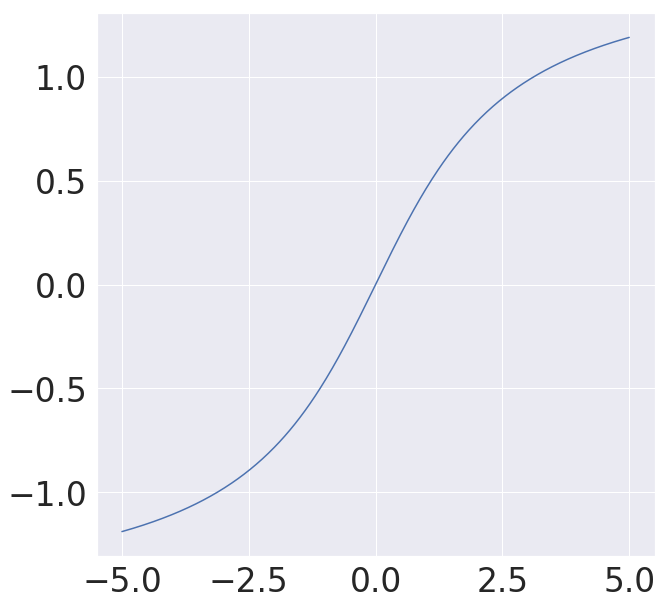

In [752]:

%matplotlib inline
alpha = 0.1

# In units of STD
n = 500
x_max = 5.0
x = np.array( [ -x_max + (2.0*x_max)*ind/(n-1) for ind in range(0,n) ] )

# y = alpha + (1.0-alpha)*(420-x)/420.0
y = np.arctan((x)*0.50)

plt.figure(figsize=(10,10))
plt.plot(x,y)

In [214]:
np.ceil(11/10.0)

2.0